<a href="https://colab.research.google.com/github/alilotfi90/Advanced-Deep-Learning-Project/blob/main/comparision-simple-vs-complex-models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 8
Due November 26 2023
***
Make sure you start EARLY! training the model will take time!

We will be working with the [CIFAR10 dataset.](https://en.wikipedia.org/wiki/CIFAR-10]) For this assignment, you will be doing all of the heavy lifting!


In [ ]:
import torch
from torchvision.datasets import CIFAR10
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

is_gpu_available = torch.cuda.is_available()
print("Is GPU available:", is_gpu_available)

Is GPU available: True


Question 1: Load the CIFAR10 dataset (~354MB). This is done the same way we downloaded FashionMNIST dataset.
- Hint: you only need to only replace the FashionMNIST to CIFAR10 in the lab notebook.

<div class="alert" style="background-color:#CC7722; color: #fff; padding: 5px">
    NOTE: CIFAR10 images are color images, so you need to transform them into grayscale. In order to transform the images to grayscale, use the <code>torchvision.transforms.Grayscale()</code> in your transform object. More info <a href="https://pytorch.org/vision/main/generated/torchvision.transforms.Grayscale.html#grayscale">here </a> about Grayscale transformation.
</div>



- Do not forget to download both the training and testing dataset!


In [ ]:
# TODO: Question 1


transform = transforms.Compose([
    transforms.Grayscale(),
])


train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)


100%|██████████| 170498071/170498071 [00:01<00:00, 94529445.93it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Explore the data!
Question 2:

1. What is the size of the image?
2. What is the training and test dataset size?
3. How many unique classes are there in the dataset?

In [ ]:
# TODO: Question 2
image_size = train_dataset[0][0].size
print(f"size of image: {image_size}")

train_dataset_size = len(train_dataset)
test_dataset_size = len(test_dataset)
print(f"Training dataset size: {train_dataset_size}")
print(f"Test dataset size: {test_dataset_size}")

num_classes = len(train_dataset.classes)
print(f"Number of unique classes: {num_classes}")

size of image: (32, 32)
Training dataset size: 50000
Test dataset size: 10000
Number of unique classes: 10


Question 3: Build a neural network to classify CIFAR10 images.

A few things to note:

1. You can decide on the number of fully connected layers to use.
2. hyperparameters to choose:
    - epochs
    - activation function
    - optimizer
    - batch size
    - loss function
3. you can break this part into more than one code block if needed!

**DO NOT** forget to store your loss and accuracy score for each epoch for both training and validation dataset. We will graph them in the next question.
    

In [ ]:
# TODO: Question 3 - Neural Network






In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import StepLR


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


train_size = int(0.8 * len(cifar10_train))
validation_size = len(cifar10_train) - train_size
train_dataset, validation_dataset = random_split(cifar10_train, [train_size, validation_size])


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)


model = Model().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    model.eval()
    val_running_loss = 0.0
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for images, labels in validation_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()


    val_loss = val_running_loss / len(validation_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Train Loss: 1.6338, Train Acc: 0.3978, Val Loss: 1.3817, Val Acc: 0.4952
Epoch 2/20, Train Loss: 1.3216, Train Acc: 0.5260, Val Loss: 1.1395, Val Acc: 0.6043
Epoch 3/20, Train Loss: 1.1827, Train Acc: 0.5832, Val Loss: 1.0532, Val Acc: 0.6342
Epoch 4/20, Train Loss: 1.0846, Train Acc: 0.6187, Val Loss: 0.9745, Val Acc: 0.6628
Epoch 5/20, Train Loss: 1.0215, Train Acc: 0.6428, Val Loss: 0.9272, Val Acc: 0.6865
Epoch 6/20, Train Loss: 0.9551, Train Acc: 0.6683, Val Loss: 0.8910, Val Acc: 0.7065
Epoch 7/20, Train Loss: 0.9135, Train Acc: 0.6834, Val Loss: 0.8230, Val Acc: 0.7238
Epoch 8/20, Train Loss: 0.8743, Train Acc: 0.6949, Val Loss: 0.7995, Val Acc: 0.7283
Epoch 9/20, Train Loss: 0.8321, Train Acc: 0.7118, Val Loss: 0.8506, Val Acc: 0.7170
Epoch 10/20, Train Loss: 0.8023, Train Acc: 0.7224, Val Loss: 0.7350, Val Acc: 0.7515
Epoch 11/20, Train Loss: 0.6989, Train Acc: 0.7608, Val Loss: 0.6849, Val

Question 4: Plot the accuracy and loss values for both the training and validation.  

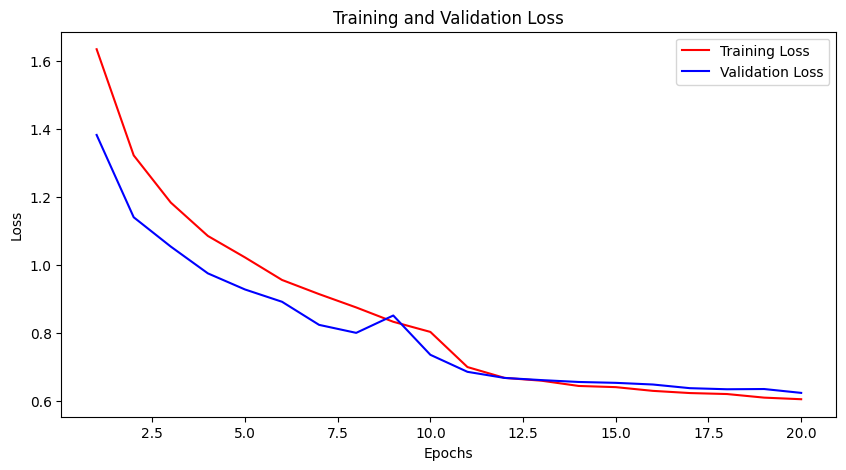

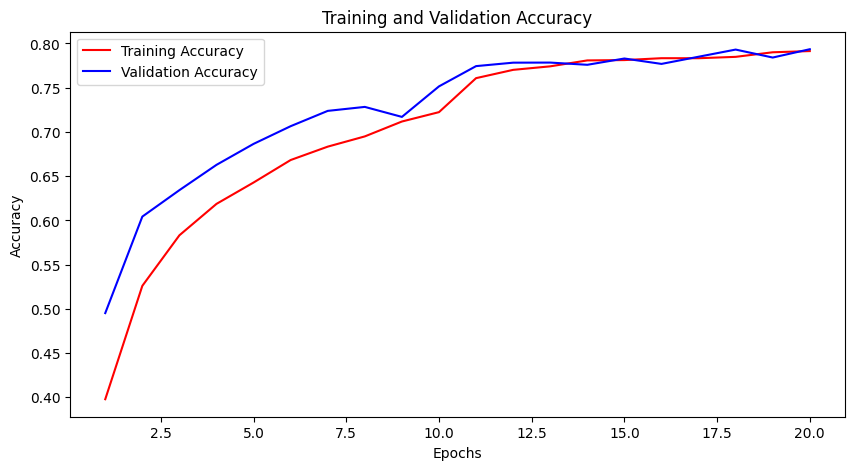

In [ ]:
# TODO: Question 4


import matplotlib.pyplot as plt


epochs = range(1, num_epochs + 1)


plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'r-', label='Training Loss')
plt.plot(epochs, val_losses, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, 'r-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Question 5: Does your model suffer from overfitting? Justify your answer!

hint: look at the graph above!

My basic Model over-fits with a max accuracy of 56%. You can see from the graph at the end of this notebook that epoch 12, the training accuracy increases while validation accuracy remains almost the same which is sign of over-fitting. Please refer to the rest of this notebook for the basic model. Then I decided to implement a CNN model to see if I can do better.

CNN experiment.
Initially I had 60% accuracy. Then by adding some data augmentations and also not changing the images to grayscale, I got it up to 67%. By adding batch normalization layers, I was able to get it up to 77%.

BONUS QUESTION: use your trained model to make predictions on the test dataset. Use a confusion matrix to show the predictions similar to lab exercise.

In [ ]:
# TODO: [Bonus] Prediction and confusion matrix.

BONUS QUESTION: Save your model and upload the weights with the `*.pth` extension. We will run your model and grade you based on the performance of your model!

In [ ]:
# TODO: [Bonus] Save your model and upload weights.
torch.save(model.state_dict(), 'model_weights.pth')


In [ ]:
import torch
import torch.nn as nn
from torch.nn import Module, Linear

class SimpleNetwork(Module):
    def __init__(self):
        super(SimpleNetwork, self).__init__()
        self.fc1 = Linear(32 * 32 * 3, 512)
        self.fc2 = Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = torch.relu(self.fc1(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.fc2(x)
        return x

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


train_size = int(0.8 * len(cifar10_train))
validation_size = len(cifar10_train) - train_size
train_dataset, validation_dataset = random_split(cifar10_train, [train_size, validation_size])


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)


model = SimpleNetwork().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


num_epochs = 20
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    model.eval()
    val_running_loss = 0.0
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for images, labels in validation_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()


    val_loss = val_running_loss / len(validation_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Train Loss: 1.7341, Train Acc: 0.3956, Val Loss: 1.5966, Val Acc: 0.4394
Epoch 2/20, Train Loss: 1.5685, Train Acc: 0.4575, Val Loss: 1.5505, Val Acc: 0.4706
Epoch 3/20, Train Loss: 1.5038, Train Acc: 0.4807, Val Loss: 1.4938, Val Acc: 0.4877
Epoch 4/20, Train Loss: 1.4496, Train Acc: 0.5027, Val Loss: 1.5062, Val Acc: 0.4875
Epoch 5/20, Train Loss: 1.4062, Train Acc: 0.5184, Val Loss: 1.4994, Val Acc: 0.4916
Epoch 6/20, Train Loss: 1.3637, Train Acc: 0.5372, Val Loss: 1.4948, Val Acc: 0.4890
Epoch 7/20, Train Loss: 1.3246, Train Acc: 0.5485, Val Loss: 1.4908, Val Acc: 0.5075
Epoch 8/20, Train Loss: 1.2885, Train Acc: 0.5604, Val Loss: 1.5067, Val Acc: 0.4988
Epoch 9/20, Train Loss: 1.2478, Train Acc: 0.5755, Val Loss: 1.5034, Val Acc: 0.5070
Epoch 10/20, Train Loss: 1.2140, Train Acc: 0.5905, Val Loss: 1.5010, Val Acc: 0.5195
Epoch 11/20, Train Loss: 0.9669, Train Acc: 0.6708, Val Loss: 1.3229, Val

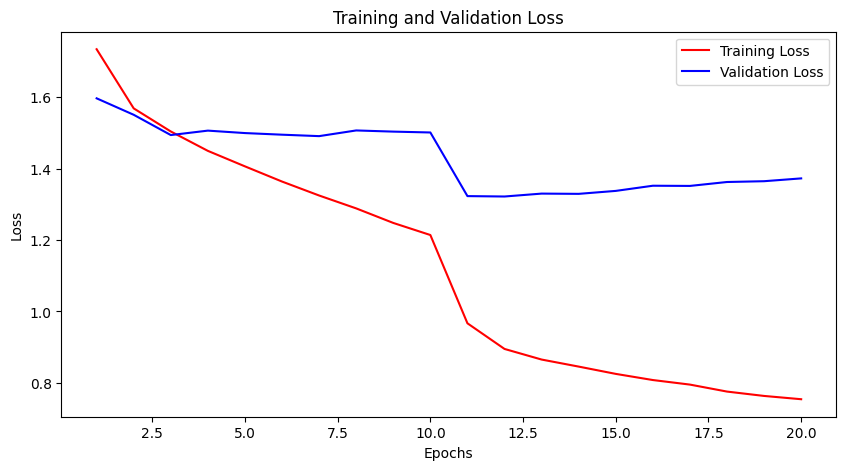

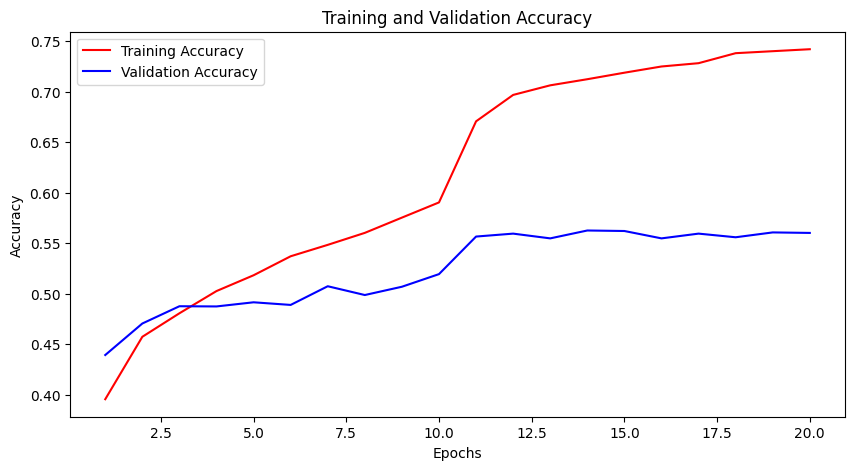

In [ ]:
epochs = range(1, num_epochs + 1)


plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'r-', label='Training Loss')
plt.plot(epochs, val_losses, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, 'r-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Files already downloaded and verified


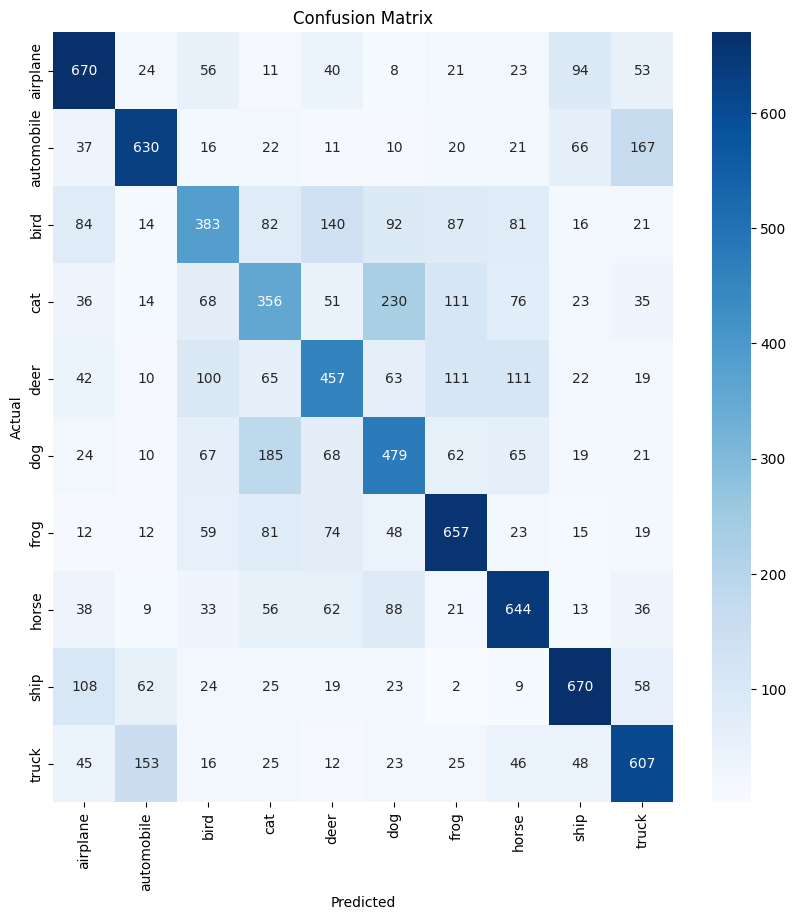

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())


cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=testset.classes, yticklabels=testset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
